# Analysis on Kickstarter

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from rdd import rdd
# Show all columns
pd.set_option('display.max_columns', None)


In [32]:
# Load the data
df = pd.read_json('../data/creator_first_project.json', lines = True)
df.shape

(328653, 139)

# Visualize the Data

Text(0.5, 1.0, 'New Kickstarter Creators by Year')

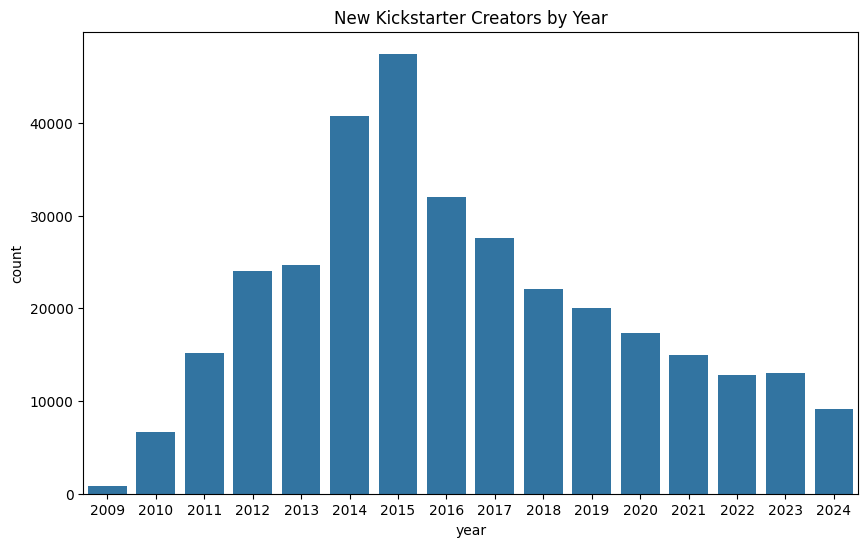

In [33]:
# New Kickstarter Creators by Year
df['year'] = df['launched_at'].dt.year
df['month'] = df['launched_at'].dt.month

# Plot
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='year')
plt.title('New Kickstarter Creators by Year')

Check first project statistics

In [34]:
# Convert some key statistics to integers
df['spotlight'] = df['spotlight'].astype(int)

# Replace missing with zeros for prelaunch_activated
df['prelaunch_activated'] = df['prelaunch_activated'].fillna(0)

In [35]:
print(df[['goal', 'pledged', 'staff_pick', 'backers_count', 'spotlight', 'prelaunch_activated']].describe().apply(lambda s: s.apply('{0:.2f}'.format)))

                goal       pledged staff_pick backers_count  spotlight  \
count      328653.00     328653.00  321020.00     328653.00  328653.00   
mean        55322.02      30048.42       0.11        129.73       0.50   
std       2102742.08    1318562.73       0.32        942.75       0.50   
min             1.00          0.00       0.00          0.00       0.00   
25%          2000.00         75.00       0.00          3.00       0.00   
50%          5000.00       1260.00       0.00         21.00       0.00   
75%         15000.00       6383.01       0.00         77.00       1.00   
max    1000000000.00  481621841.00       1.00     219382.00       1.00   

      prelaunch_activated  
count           328653.00  
mean                 0.08  
std                  0.28  
min                  0.00  
25%                  0.00  
50%                  0.00  
75%                  0.00  
max                  1.00  


Define the Discontinuity

In [36]:
# Create Discontinuity Columns
df['percent_to_goal'] = df['pledged'] / df['goal']
df['dollars_to_goal'] = df['pledged']  - df['goal']

Plot the density near the discontinuity

## Percent to Goal

C:\Users\d0tam\AppData\Local\Temp\ipykernel_26460\3780869677.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df[f"{variable}_binned"] = pd.cut(left_df[variable], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_26460\3780869677.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df[f"{variable}_binned"] = pd.cut(right_df[variable], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_26460\3780869677.py:22: FutureWarning: The default of observed=False is deprecated and will be changed t

<Axes: xlabel='percent_to_goal', ylabel='Count'>

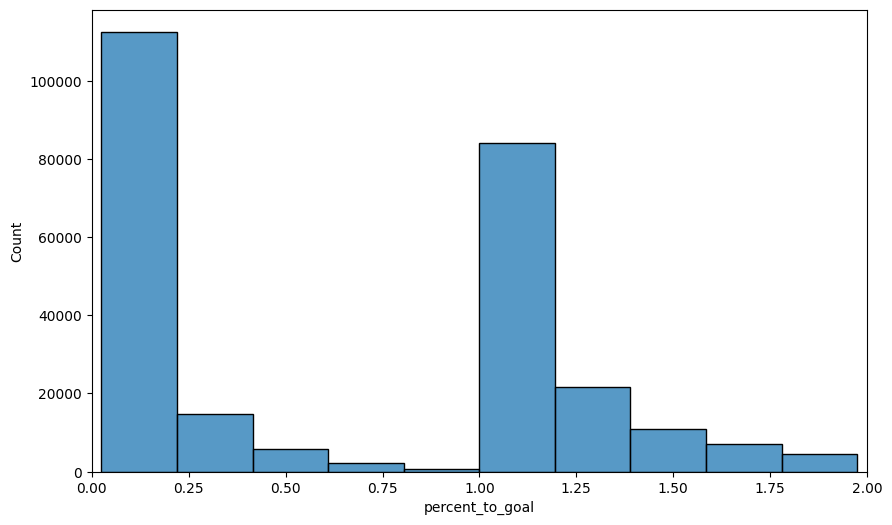

In [37]:
# Create a plotting dataframe
# Define the cutoff point
cutoff_perc = 1  # Adjust this value based on your specific cutoff criteria


def generate_plotting_df(variable, cuttoff_perc, bins):
    # Create a copy of the DataFrame
    plotting_df = df.copy()

    # Remove outliers
    plotting_df = plotting_df[(plotting_df[variable] <= 2) & (plotting_df[variable] > 0)]

    # Split data into left and right of the cutoff
    left_df = plotting_df[plotting_df[variable] < cutoff_perc]
    right_df = plotting_df[plotting_df[variable] >= cutoff_perc]

    # Bin each subset separately
    left_df[f"{variable}_binned"] = pd.cut(left_df[variable], bins=20)
    right_df[f"{variable}_binned"] = pd.cut(right_df[variable], bins=20)

    # Aggregate the binned data for each subset
    left_binned_data = left_df.groupby(f"{variable}_binned").agg({
        'total_successful_after_first': 'mean',
        'total_failed_after_first': 'mean',
        'total_canceled_after_first': 'mean',
        'total_raised_after_first': 'sum',
        'total_campaigns_after_first': 'mean',
        variable: 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={variable: 'n_obs'})
    right_binned_data = right_df.groupby(f"{variable}_binned").agg({
        'total_successful_after_first': 'mean',
        'total_failed_after_first': 'mean',
        'total_canceled_after_first': 'mean',
        'total_raised_after_first': 'sum',
        'total_campaigns_after_first': 'mean',
        variable: 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={variable: 'n_obs'})

    # Add a midpoint for each bin for both left and right data
    left_binned_data[variable] = left_binned_data[f"{variable}_binned"].apply(lambda interval: interval.mid)
    right_binned_data[variable] = right_binned_data[f"{variable}_binned"].apply(lambda interval: interval.mid)

    # Combine the binned data for both sides of the cutoff
    plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)

    # Add Threshold Column
    plotting_df['threshold'] = plotting_df[variable] >= cutoff_perc
    return plotting_df

plotting_df = generate_plotting_df('percent_to_goal', cutoff_perc, 20)

# Plot percent to goal on x axis and total number of projects on y axis
plt.figure(figsize=(10,6))
plt.xlim(0, 2)
sns.histplot(data=plotting_df, x='percent_to_goal', weights = 'n_obs')

Text(0.5, 0, 'Percent to Goal')

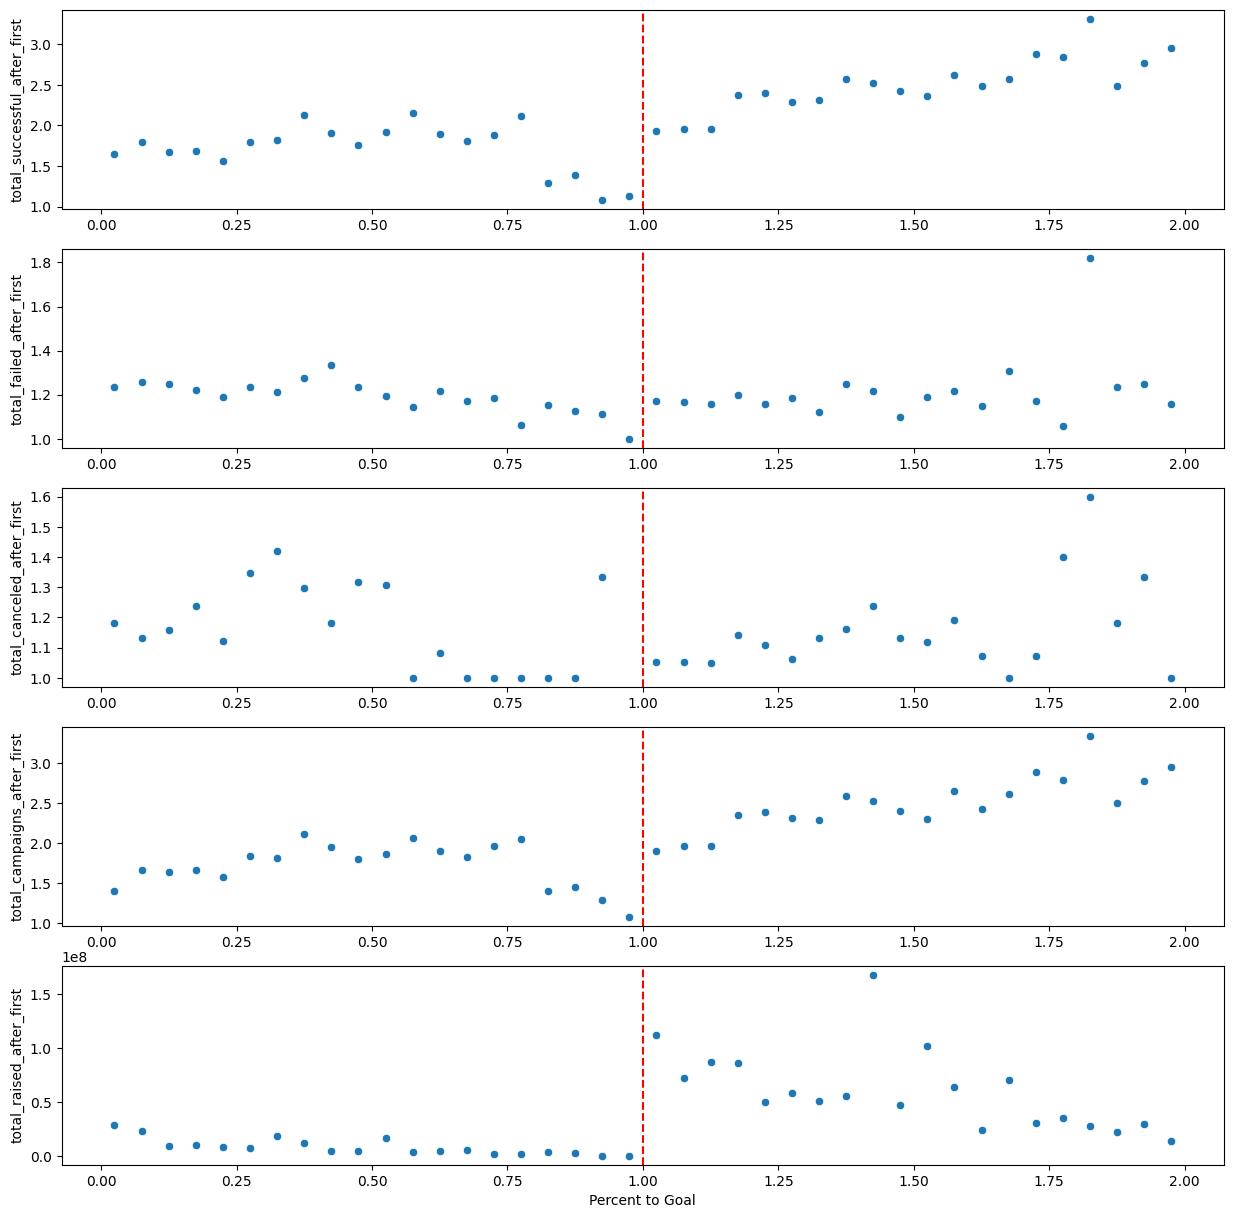

In [38]:
plt.figure(figsize=(15,15))
ax = plt.subplot(5, 1, 1)

sns.scatterplot(data=plotting_df, x = 'percent_to_goal', y = 'total_successful_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 2)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_failed_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 3)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_canceled_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 4)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_campaigns_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 5)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_raised_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('Percent to Goal')


In [39]:
plotting_df

,percent_to_goal_binned,total_successful_after_first,total_failed_after_first,total_canceled_after_first,total_raised_after_first,total_campaigns_after_first,n_obs,percent_to_goal,threshold
0,"(-0.001, 0.05]",1.648805,1.235171,1.180301,2.852479e+07,1.402621,80377,0.0245,False
1,"(0.05, 0.1]",1.793201,1.257709,1.130435,2.285252e+07,1.663172,15566,0.0750,False
2,"(0.1, 0.15]",1.677966,1.248016,1.157143,9.270335e+06,1.635342,9886,0.1250,False
3,"(0.15, 0.2]",1.688841,1.223188,1.238095,1.056213e+07,1.670199,6765,0.1750,False
4,"(0.2, 0.25]",1.563348,1.189474,1.121212,8.151370e+06,1.576071,5317,0.2250,False
5,"(0.25, 0.3]",1.800000,1.233831,1.346154,7.615889e+06,1.837338,3854,0.2750,False
6,"(0.3, 0.35]",1.823344,1.212329,1.421053,1.823006e+07,1.813901,3272,0.3250,False
7,"(0.35, 0.4]",2.134058,1.275229,1.296296,1.198105e+07,2.119444,2371,0.3750,False
8,"(0.4, 0.45]",1.901786,1.333333,1.181818,4.537201e+06,1.947735,1937,0.4250,False
9,"(0.45, 0.5]",1.761111,1.236842,1.315789,4.629892e+06,1.801653,1448,0.4750,False


## Dollars to Goal

C:\Users\d0tam\AppData\Local\Temp\ipykernel_26460\647394870.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_26460\647394870.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_26460\647394870.py:19: FutureWarning: The default of observed=False is deprecate

<Axes: xlabel='dollars_to_goal', ylabel='Count'>

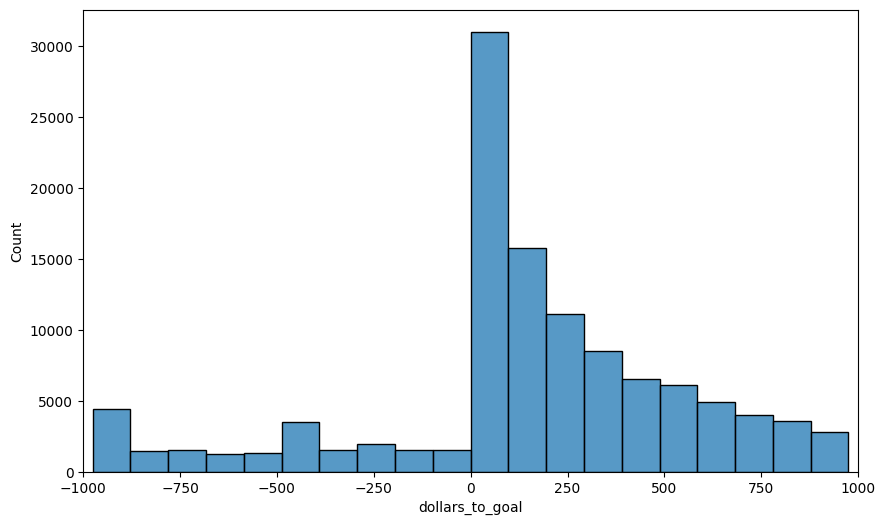

In [40]:
# Create a plotting dataframe
# Define the cutoff point
cutoff_abs = 0  # Adjust this value based on your specific cutoff criteria

# Create a copy of the DataFrame
plotting_df = df.copy()

# Remove outliers
plotting_df = plotting_df[(plotting_df['dollars_to_goal'] <= 1000) & (plotting_df['dollars_to_goal'] >= -1000)]
# Split data into left and right of the cutoff
left_df = plotting_df[(plotting_df['state'] == 'failed') & (plotting_df['dollars_to_goal'] < cutoff_abs)]
right_df = plotting_df[(plotting_df['state'] == 'successful') & (plotting_df['dollars_to_goal'] >= cutoff_abs)]

# Bin each subset separately
left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=20)
right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=20)

# Aggregate the binned data for each subset
left_binned_data = left_df.groupby('dollars_to_goal_binned').agg({
    'total_successful_after_first': 'mean',
    'total_failed_after_first': 'mean',
    'total_canceled_after_first': 'mean',
    'total_raised_after_first': 'sum',
    'total_campaigns_after_first': 'mean',
    'dollars_to_goal': 'size'  # Counts the number of observations in each bin
}).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})
right_binned_data = right_df.groupby('dollars_to_goal_binned').agg({
    'total_successful_after_first': 'mean',
    'total_failed_after_first': 'mean',
    'total_canceled_after_first': 'mean',
    'total_raised_after_first': 'sum',
    'total_campaigns_after_first': 'mean',
    'dollars_to_goal': 'size'  # Counts the number of observations in each bin
}).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})

# Add a midpoint for each bin for both left and right data
left_binned_data['dollars_to_goal'] = left_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)
right_binned_data['dollars_to_goal'] = right_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)

# Combine the binned data for both sides of the cutoff
plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)

# Add Threshold Column
plotting_df['threshold'] = plotting_df['dollars_to_goal'] >= cutoff_abs

# Plot percent to goal on x axis and total number of projects on y axis
plt.figure(figsize=(10,6))
plt.xlim(-1000, 1000)
sns.histplot(data=plotting_df, x='dollars_to_goal', weights = 'n_obs', bins = 20)

Text(0.5, 0, 'Dollars to Goal')

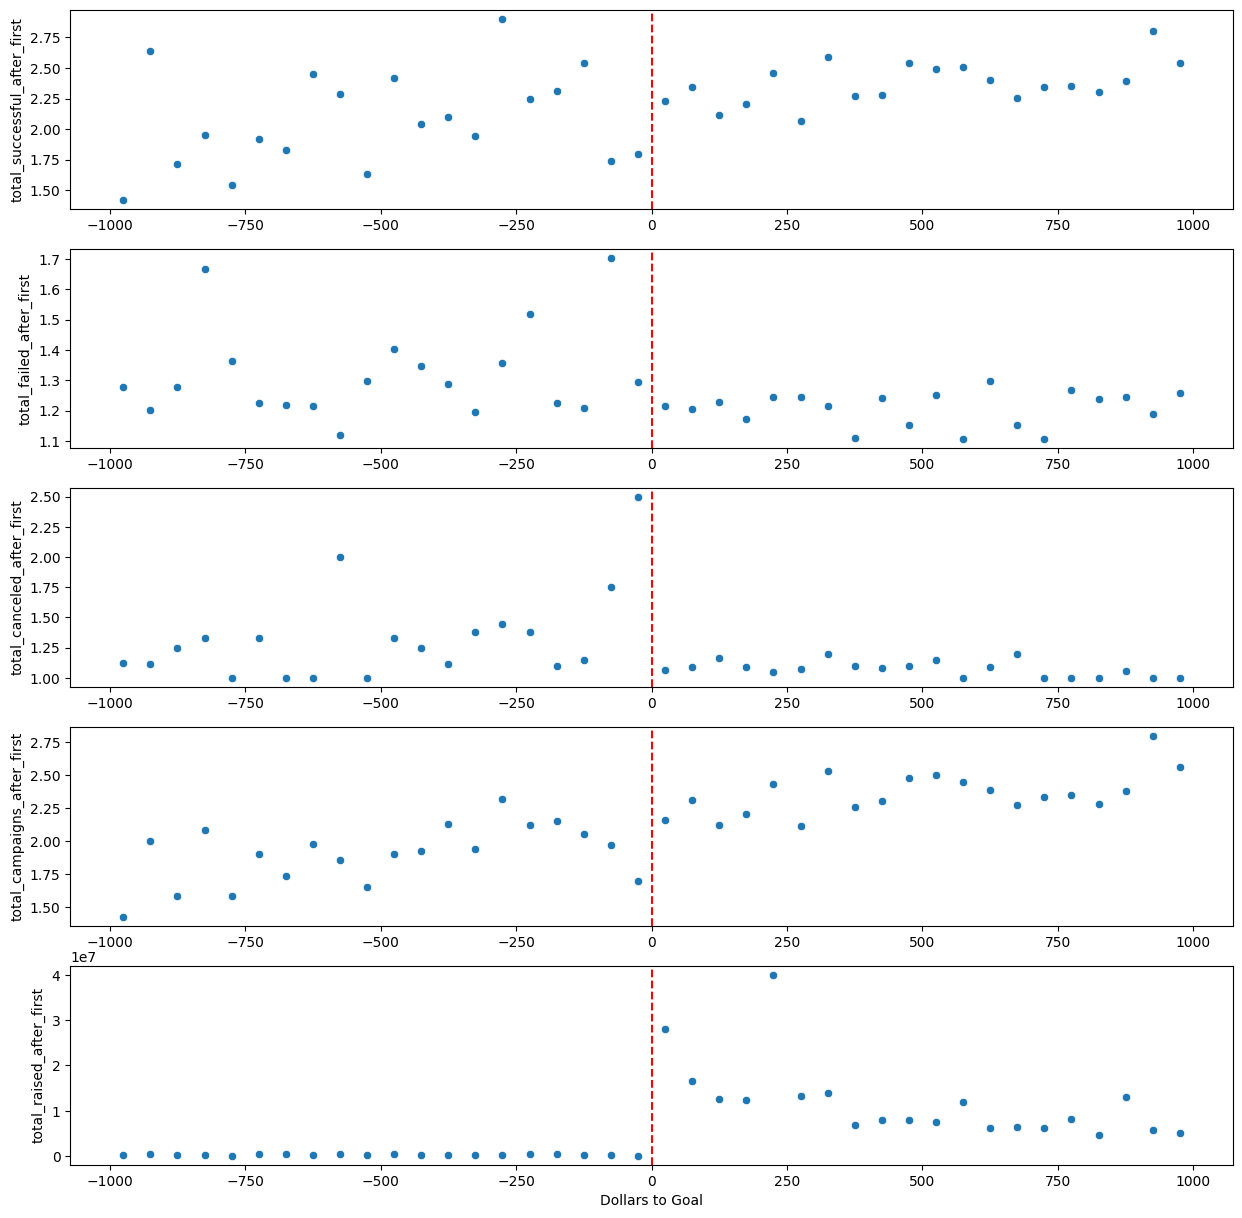

In [41]:
plt.figure(figsize=(15,15))
ax = plt.subplot(5, 1, 1)

sns.scatterplot(data=plotting_df, x = 'dollars_to_goal', y = 'total_successful_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 2)
sns.scatterplot(data = plotting_df, x = 'dollars_to_goal', y = 'total_failed_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 3)
sns.scatterplot(data = plotting_df, x = 'dollars_to_goal', y = 'total_canceled_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 4)
sns.scatterplot(data = plotting_df, x = 'dollars_to_goal', y = 'total_campaigns_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 5)
sns.scatterplot(data = plotting_df, x = 'dollars_to_goal', y = 'total_raised_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('Dollars to Goal')


In [42]:
plotting_df

,dollars_to_goal_binned,total_successful_after_first,total_failed_after_first,total_canceled_after_first,total_raised_after_first,total_campaigns_after_first,n_obs,dollars_to_goal,threshold
0,"(-1001.0, -950.01]",1.420290,1.277778,1.125000,318207.19,1.429752,3454,-975.505,False
1,"(-950.01, -900.02]",2.642857,1.203125,1.111111,363961.91,2.000000,961,-925.015,False
2,"(-900.02, -850.03]",1.710526,1.276596,1.250000,230822.74,1.585366,840,-875.025,False
3,"(-850.03, -800.04]",1.947368,1.666667,1.333333,280883.93,2.089744,578,-825.035,False
4,"(-800.04, -750.05]",1.538462,1.363636,1.000000,108373.31,1.589744,782,-775.045,False
5,"(-750.05, -700.06]",1.918367,1.224490,1.333333,371514.50,1.903614,727,-725.055,False
6,"(-700.06, -650.07]",1.825000,1.217391,1.000000,365213.44,1.734177,779,-675.065,False
7,"(-650.07, -600.08]",2.448276,1.214286,1.000000,277352.67,1.981818,484,-625.075,False
8,"(-600.08, -550.09]",2.285714,1.120000,2.000000,420794.37,1.855422,825,-575.085,False
9,"(-550.09, -500.1]",1.633333,1.297297,1.000000,140747.37,1.655738,496,-525.095,False


# Discontinuity Analysis

## Percent to Goal

In [43]:
rdd_df = df.assign(threshold = (df['percent_to_goal'] > 1).astype(int)).sort_values('percent_to_goal').reset_index(drop=True)
rdd_df['percent_to_goal*threshold'] = rdd_df['percent_to_goal'] * rdd_df['threshold']

Naive Model

In [44]:
model = smf.wls('total_successful_after_first ~ percent_to_goal + threshold + percent_to_goal*threshold', rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7093,0.068,25.081,0.000,1.576,1.843
percent_to_goal,0.1570,0.187,0.840,0.401,-0.209,0.523
threshold,0.9046,0.072,12.557,0.000,0.763,1.046
percent_to_goal:threshold,-0.1561,0.187,-0.836,0.403,-0.522,0.210


C:\Users\d0tam\AppData\Local\Temp\ipykernel_26460\3780869677.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df[f"{variable}_binned"] = pd.cut(left_df[variable], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_26460\3780869677.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df[f"{variable}_binned"] = pd.cut(right_df[variable], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_26460\3780869677.py:22: FutureWarning: The default of observed=False is deprecated and will be changed t

Text(0.5, 1.0, 'Regression Discontinuity')

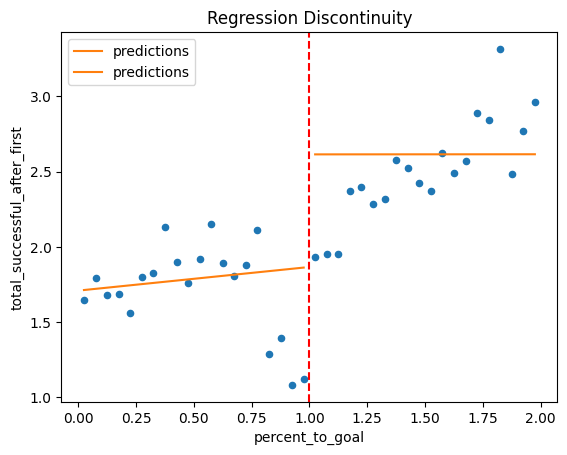

In [45]:
# Remove outliers
plotting_df = generate_plotting_df('percent_to_goal', 1, 20)


ax = plotting_df.plot.scatter(x = 'percent_to_goal', y = 'total_successful_after_first', color = "C0")

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['percent_to_goal*threshold'] = plotting_df['percent_to_goal'] * plotting_df['threshold']

exog_dict = {"percent_to_goal": plotting_df['percent_to_goal'].values, "threshold": plotting_df['threshold'].values, "percent_to_goal*threshold": plotting_df['percent_to_goal*threshold'].values}
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['percent_to_goal'] < 1]
right_plotting_df = plotting_df[plotting_df['percent_to_goal'] >= 1]
left_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
right_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
plt.title('Regression Discontinuity')

Kernel weighted RD

In [46]:
def kernel(R, c, h):
    indicator = (np.abs(R - c) <= h).astype(float)
    return indicator * (1 - np.abs(R - c) / h)

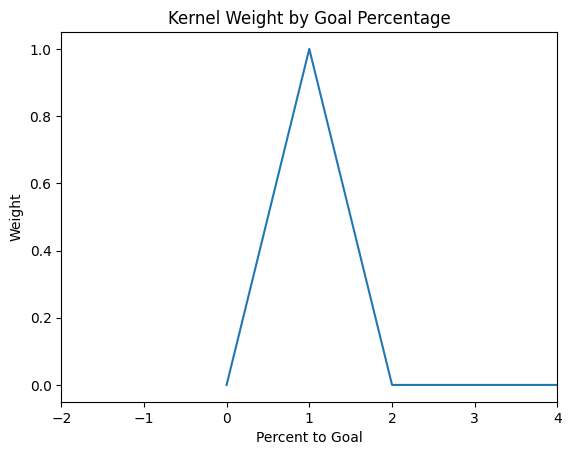

In [47]:
plt.plot(sorted(rdd_df["percent_to_goal"]), kernel(rdd_df["percent_to_goal"], c=1, h=1))
plt.xlabel("Percent to Goal")
plt.ylabel("Weight")
plt.xlim(-2, 4)
plt.title("Kernel Weight by Goal Percentage");

In [48]:
model = smf.wls("total_successful_after_first ~ percent_to_goal*threshold", data = rdd_df, weights = kernel(rdd_df['percent_to_goal'], c=1, h=1)).fit()

model.summary().tables[1]

c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8638,0.111,16.835,0.000,1.647,2.081
percent_to_goal,-0.1386,0.184,-0.752,0.452,-0.500,0.223
threshold,-1.1222,0.172,-6.516,0.000,-1.460,-0.785
percent_to_goal:threshold,1.3393,0.214,6.246,0.000,0.919,1.760


Text(0.5, 1.0, 'Regression Discontinuity')

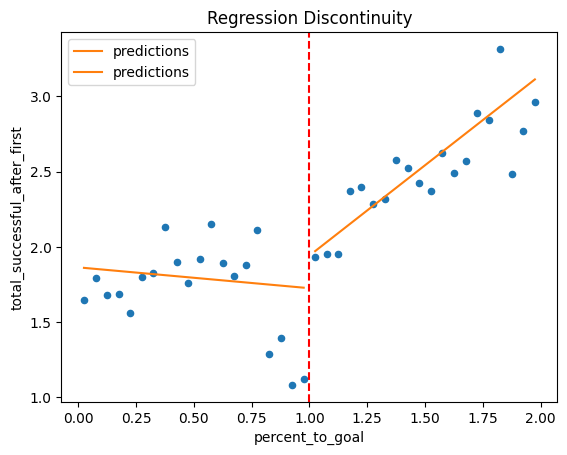

In [49]:
ax = plotting_df.plot.scatter(x = 'percent_to_goal', y = 'total_successful_after_first', color = "C0")

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['percent_to_goal*threshold'] = plotting_df['percent_to_goal'] * plotting_df['threshold']

exog_dict = {"percent_to_goal": plotting_df['percent_to_goal'].values, "threshold": plotting_df['threshold'].values, "percent_to_goal*threshold": plotting_df['percent_to_goal*threshold'].values}
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['percent_to_goal'] < 1]
right_plotting_df = plotting_df[plotting_df['percent_to_goal'] >= 1]
left_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
right_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
plt.title('Regression Discontinuity')

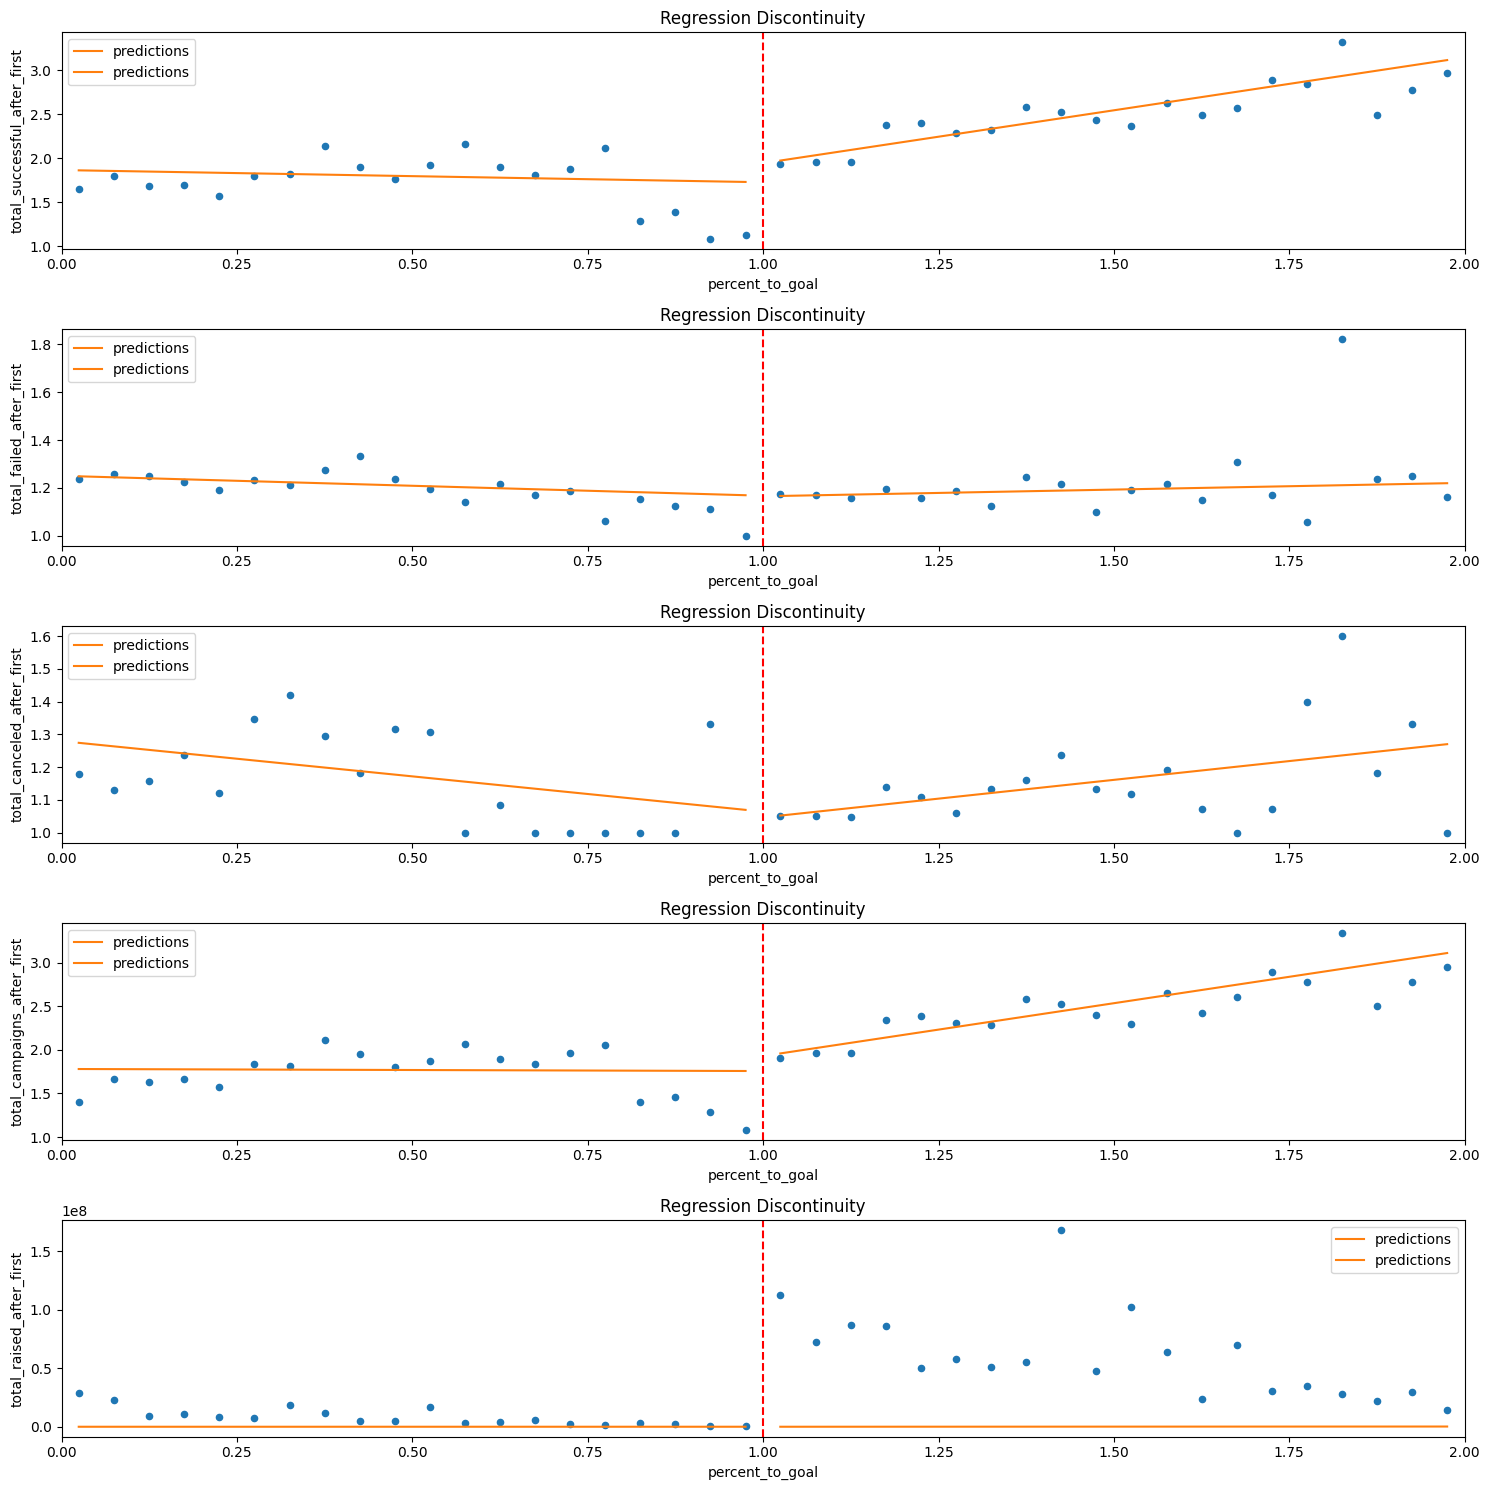

In [50]:
plt.figure(figsize=(15,15))


exog_dict = {"percent_to_goal": plotting_df['percent_to_goal'].values, "threshold": plotting_df['threshold'].values, "percent_to_goal*threshold": plotting_df['percent_to_goal*threshold'].values}
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['percent_to_goal*threshold'] = plotting_df['percent_to_goal'] * plotting_df['threshold']

for p, cause in enumerate(["total_successful_after_first", "total_failed_after_first", "total_canceled_after_first", "total_campaigns_after_first", "total_raised_after_first"], 1):
    ax = plt.subplot(5,1,p)
    ax = plotting_df.plot.scatter(x = 'percent_to_goal', y = cause, color = "C0", ax = ax)

    m = smf.wls(f"{cause}~percent_to_goal*threshold", rdd_df, weights = kernel(rdd_df['percent_to_goal'], c=1, h=1)).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)

    plt.title(f"Impact of Kickstarter on {cause}: {np.round(ate_pct, 2)}%")
    # Convert threshold to int

    plotting_df['predictions'] = m.predict(exog_dict)
    left_plotting_df = plotting_df[plotting_df['percent_to_goal'] < 1]
    right_plotting_df = plotting_df[plotting_df['percent_to_goal'] >= 1]
    left_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
    right_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
    ax.axvline(x = 1, color = 'red', linestyle = '--')
    plt.title('Regression Discontinuity')
    plt.legend()

    plt.xlim(0, 2)
    
    

plt.tight_layout()

## Dollars to Goal

In [51]:
rdd_df = df.assign(threshold = (df['dollars_to_goal'] > 1).astype(int)).sort_values('dollars_to_goal').reset_index(drop=True)
rdd_df['dollars_to_goal*threshold'] = rdd_df['dollars_to_goal'] * rdd_df['threshold']

Naive Model

In [52]:
model = smf.wls('total_successful_after_first ~ dollars_to_goal + threshold + dollars_to_goal*threshold', rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7685,0.049,36.390,0.000,1.673,1.864
dollars_to_goal,9.79e-08,1.34e-07,0.733,0.464,-1.64e-07,3.6e-07
threshold,0.8527,0.054,15.807,0.000,0.747,0.958
dollars_to_goal:threshold,-1.334e-07,1.37e-07,-0.973,0.330,-4.02e-07,1.35e-07


# McCrary Test

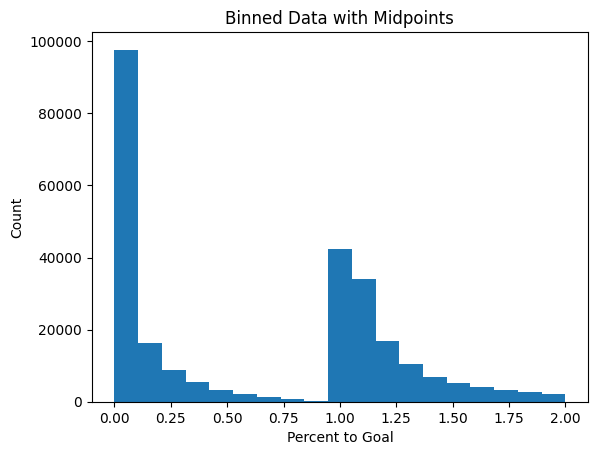

In [53]:
bins = np.linspace(0, 2, 20)

rdd_df['bin'] = pd.cut(rdd_df['percent_to_goal'], bins)

# Get Bin Counts
bin_counts = rdd_df['bin'].value_counts(sort = False)

# Calculate the midpoints for each bin
midpoints = bins[:-1] + (bins[1:] - bins[:-1]) / 2

# Plot the bar plot
plt.bar(midpoints, bin_counts, width=(bins[1] - bins[0]), align='center')
plt.xlabel('Percent to Goal')
plt.ylabel('Count')
plt.title('Binned Data with Midpoints')
plt.show()


# RD Analysis with Optimal Bandwidth (IK)

Set Thresholds

In [54]:
perc_threshold = 1
abs_threshold = 0

Identify Optimal Bandwidth

In [55]:
bandwidth_opt_perc = rdd.optimal_bandwidth(X = rdd_df['percent_to_goal'], Y = rdd_df['total_successful_after_first'], cut=perc_threshold)
bandwidth_opt_abs = rdd.optimal_bandwidth(X = rdd_df['dollars_to_goal'], Y = rdd_df['total_successful_after_first'], cut=abs_threshold)
print("Optimal Percentage bandwidth:", bandwidth_opt_perc)
print("Optimal Absolute bandwidth:", bandwidth_opt_abs)

Optimal Percentage bandwidth: 0.44001092043097434
Optimal Absolute bandwidth: 10.350557445272125


Restrict Data to Optimal Bandwidth

In [56]:
perc_rdd_df = rdd.truncated_data(rdd_df, 'percent_to_goal', bandwidth_opt_perc, cut=perc_threshold)

#abs_rdd_df = rdd.truncated_data(rdd_df, 'dollars_to_goal', bandwidth_opt_abs, cut=abs_threshold)
abs_rdd_df = rdd.truncated_data(rdd_df, 'dollars_to_goal', 1000, cut=abs_threshold)

print(f"Percentage RDD Shape: {perc_rdd_df.shape}")
print(f"Absolute RDD Shape: {abs_rdd_df.shape}")



Percentage RDD Shape: (112013, 146)
Absolute RDD Shape: (116453, 146)


## Dollars to Goal

In [57]:
model = smf.wls("total_successful_after_first ~ dollars_to_goal*threshold", data = abs_rdd_df, weights = kernel(abs_rdd_df['dollars_to_goal'], c=abs_threshold, h=bandwidth_opt_abs)).fit()

model.summary().tables[1]


c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7383,0.055,31.342,0.000,1.630,1.847
dollars_to_goal,1.0393,0.109,9.515,0.000,0.825,1.253
threshold,1.2955,0.197,6.587,0.000,0.910,1.681
dollars_to_goal:threshold,-1.1568,0.116,-9.934,0.000,-1.385,-0.929


In [58]:
ate_pct = 100*((model.params["threshold"] + model.params["Intercept"])/model.params["Intercept"] - 1)
print(f"Impact of Winning First Kickstarter on Total Successful Projects: {np.round(ate_pct, 2)}%")

Impact of Winning First Kickstarter on Total Successful Projects: 74.52%


## Percent to Goal

In [59]:
model = smf.wls("total_successful_after_first ~ percent_to_goal*threshold", data = perc_rdd_df, weights = kernel(perc_rdd_df['percent_to_goal'], c=perc_threshold, h=bandwidth_opt_perc)).fit()

model.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.4207,0.910,1.562,0.118,-0.362,3.204
percent_to_goal,0.4860,0.970,0.501,0.616,-1.414,2.386
threshold,-1.3116,0.985,-1.332,0.183,-3.242,0.619
percent_to_goal:threshold,1.2758,1.028,1.241,0.214,-0.738,3.290


In [60]:
ate_pct = 100*((model.params["threshold"] + model.params["Intercept"])/model.params["Intercept"] - 1)
print(f"Impact of Winning First Kickstarter on Total Successful Projects: {np.round(ate_pct, 2)}%")

Impact of Winning First Kickstarter on Total Successful Projects: -92.32%
